# 1.9 Exercises
## 1.9.1 Business Cycle Regularities in India and the United States
In this exercise, you are asked to analyze the extent to which the numbered business cycle facts discussed in this chapter apply to (a)India and (b) The United States. To this end, compute the relevant business cycle statistics for the following four alternative detrending methods:
(a) log-linear detrending;
(b) log-quadratic detrending;
(c) Hodrick Prescott filtering with λ = 100;
(d) Hodrick Prescott filtering with λ = 6.25.

Make a two by two graph showing the natural logarithm of real per capita GDP and the trend, one panel per trend. Discuss how the detrending method influences the volatility of the cyclical component of output. Also discuss which detrending method identifies recessions for the U.S. most in line with the NBER business cycle dates. The data should be downloaded from the World Bank’s WDI database. For the sample period, use 1960 to 2022 for South Korea and 1965 to 2022 for the United States. Specifically, use the following time series to construct the required business cycle statistics:

GDP per capita (constant LCU) NY.GDP.PCAP.KN

Household final consumption expenditure, etc. (% of GDP) NE.CON.PETC.ZS

Gross capital formation (% of GDP) NE.GDI.TOTL.ZS

General government final consumption expenditure (% of GDP) NE.CON.GOVT.ZS

Imports of goods and services (% of GDP) NE.IMP.GNFS.ZS

Exports of goods and services (% of GDP) NE.EXP.GNFS.ZS

## Подготовка данных

Импортируем библиотеки

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
import statsmodels.api as sm

Подготавливам запрос к API World Bank

In [4]:
# Массив индикаторов
indicators = [
    'NY.GDP.PCAP.KN',  
    'NE.CON.PRVT.ZS',  
    'NE.GDI.TOTL.ZS',  
    'NE.CON.GOVT.ZS',  
    'NE.IMP.GNFS.ZS',  
    'NE.EXP.GNFS.ZS'  
]
# Словарь описаний индикаторов
indicators_info = {
    indicators[0]:'GDP per capita',    
    indicators[1]:'Households and NPISHs final consumption expenditure',    
    indicators[2]:'Gross capital formation',    
    indicators[3]:'General government final consumption expenditure',    
    indicators[4]:'Imports of goods and services',    
    indicators[5]:'Exports of goods and services',    
}

def get_data(country):
    url = f'https://api.worldbank.org/v2/country/{country}/indicator/'
    imported_data = pd.DataFrame(columns = ['Country', 'Indicator', 'Year', 'Value'])

    for indicator in indicators:
        api_url = url + indicator

        response = requests.get(api_url, params = {
            'format': 'json',
            'per_page': 500 })

        if response.status_code == 200:
            data = response.json()
            if len(data) <= 1:
                continue
            else:
                # Обработка полученных данных
                for entry in data[1]:
                    new_row = pd.Series([entry['country']['value'], indicator, entry['date'], entry['value']], index = imported_data.columns)
                    imported_data.loc[len(imported_data)] =  new_row
        else:
            print('Error retrieving data.')
    return imported_data


Получение данных

In [23]:
usa_data = get_data('US')  # United States
ind_data = get_data('IN')  # India

C:\Users\Владимир\AppData\Local\Temp\ipykernel_6004\3145001544.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imported_data.loc[len(imported_data)] =  new_row
C:\Users\Владимир\AppData\Local\Temp\ipykernel_6004\3145001544.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  imported_data.loc[len(imported_data)] =  new_row
C:\Users\Владимир\AppData\Local\Temp\ipykernel_6004\3145001544.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. I

Проверим корректность данных

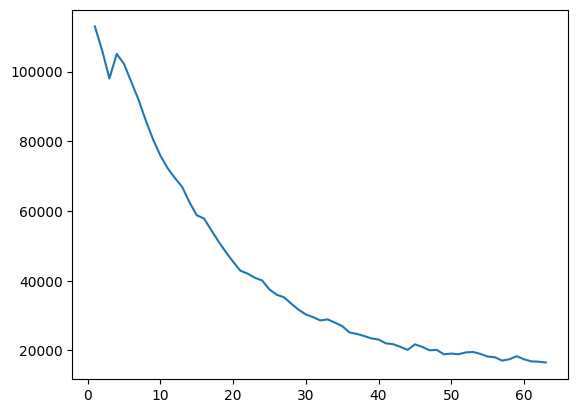

In [18]:
plt.plot(ind_data[ind_data.Indicator == indicators[0]].Value)

Данные загружены в обратном порядке. Реиндексируем

In [25]:
usa_data = usa_data.iloc[::-1].reset_index().drop('index', axis=1)
ind_data = ind_data.iloc[::-1].reset_index().drop('index', axis=1)

Возьмём интервал с 1971 по 2022

In [26]:
usa_data = usa_data[(usa_data.Year.astype(int) >= 1971) & (usa_data.Year.astype(int) <= 2022)]
ind_data = ind_data[(ind_data.Year.astype(int) >= 1971) & (ind_data.Year.astype(int) <= 2022)]

Строим график, не удивляемся, что Индия выше по ВВП на душу чем США - график в местной валюте. =)

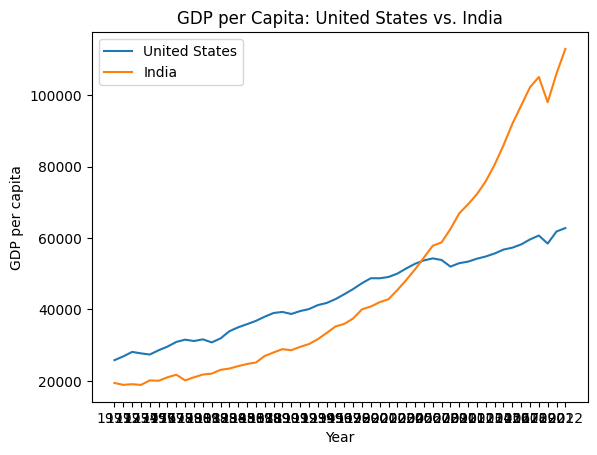

In [27]:
plt.plot(usa_data[usa_data.Indicator == indicators[0]].Year, usa_data[usa_data.Indicator == indicators[0]].Value, label='United States')
plt.plot(ind_data[ind_data.Indicator == indicators[0]].Year, ind_data[ind_data.Indicator == indicators[0]].Value, label='India')
plt.legend()
plt.xlabel('Year')
plt.ylabel(indicators_info[indicators[0]])
plt.title('GDP per Capita: United States vs. India')
plt.show()


### Логарифмируем значения

In [28]:
usa_data_log = usa_data.copy()
ind_data_log = ind_data.copy()

for indicator in indicators:
    usa_data_log.loc[usa_data_log.Indicator == indicator, 'Value'] = \
        np.log(usa_data[usa_data.Indicator == indicator]['Value'].astype(float))
    ind_data_log.loc[ind_data_log.Indicator == indicator, 'Value'] = \
        np.log(ind_data[ind_data.Indicator == indicator]['Value'].astype(float))

Мы подготовили данные к моделированию

## Часть I

### Пропишем все нужные в дальнейшем функции

Реализация методов удаления тренда: (a) log-linear detrending; (b) log-quadratic detrending; (c) Hodrick Prescott filtering with λ = 100; (d) Hodrick Prescott filtering with λ = 6.25. 

In [29]:
methods = ['log-linear', 'log-quad', 'hp-filter100', 'hp-filter6.25']

# (a) log-linear detrending
def log_linear_detrending(input_data, indicator='NY.GDP.PCAP.KN', is_print_summary=True):
    data = pd.DataFrame({
        'x': input_data[input_data.Indicator == indicator].Value.astype(float),
        'y': input_data[input_data.Indicator == indicator].Year.astype(int)
    })
    data = sm.add_constant(data)
    model = sm.OLS(data['x'], data[['const', 'y']])
    result = model.fit()
    if is_print_summary:
        print("Statistics for log_linear_detrending")
        print(result.summary())
    trend = result.predict(data[['const', 'y']])
    cycle = data['x'] - trend
    return cycle, trend

# (b) log-quadratic detrending
def log_quad_detrending(input_data, indicator='NY.GDP.PCAP.KN', is_print_summary=True):
    data = pd.DataFrame({
        'x': input_data[input_data.Indicator == indicator].Value.astype(float),
        'y': input_data[input_data.Indicator == indicator].Year.astype(int)
    })
    coefs = np.polyfit(data.y, data.x, 2) 
    trend = np.polyval(coefs, data.y)
    cycle = data['x'] - trend
    if is_print_summary:
        print("\nStatistics for log_quad_detrending")
        print(pd.DataFrame(trend).describe())
    return cycle, trend

# (c) Hodrick Prescott filtering with λ = 100; (d) Hodrick Prescott filtering with λ = 6.25
def hp_filter(input_data, indicator='NY.GDP.PCAP.KN', lambda_value=100, is_print_summary=True):
    cycle, trend = sm.tsa.filters.hpfilter(input_data[input_data.Indicator == indicator].Value.astype(float), lambda_value)
    if is_print_summary:
        print(f"\nStatistics for hp_filter with lambda = {lambda_value}")
        print(pd.DataFrame(trend).describe())
    return cycle, trend


Функции визуализации

In [39]:
def show_plot(ticks, x_data, y_data_1, y_data_2, y_data_1_label, y_data_2_label):
    _, axs = plt.subplots(1, 1, figsize=(10, 6))
    axs.set_xticks(ticks)
    axs.set_xlabel("Year")
    axs.plot(x_data, y_data_1, label=y_data_1_label)
    axs.plot(x_data, y_data_2, label=y_data_2_label)
    axs.legend()
    plt.tight_layout()
    plt.show()

def show_data_by_indicator(y_data_1, y_data_2, y_data_1_label, y_data_2_label, indicator='NY.GDP.PCAP.KN'):
    year_array = y_data_1[y_data_1.Indicator == indicator].Year.astype(int)
    ticks = np.arange(int(min(year_array)), int(max(year_array)) + 1, 10)
    y_1 = y_data_1[y_data_1.Indicator == indicator].Value
    y_2 = y_data_2
    show_plot(ticks, year_array, y_1, y_2, y_data_1_label, y_data_2_label)

def show_oneline_plot(ticks, x_data, y_data_1, y_data_1_label):
    _, axs = plt.subplots(1, 1, figsize=(10, 6))
    axs.set_xticks(ticks)
    axs.set_xlabel("Year")
    axs.plot(x_data, y_data_1, label=y_data_1_label)
    axs.axhline(y=0, color='red', linestyle='--')
    axs.legend()
    plt.tight_layout()
    plt.show()

In [40]:
# Method to execute the first part of the task (displaying GDP graphs for different cycles)
def solve_first_part_of_task(data, indicators):
    # Get cycle and trend for log-linear
    cycle_ll, trend_ll = log_linear_detrending(data)
    # Get cycle and trend for log-quadratic
    cycle_lq, trend_lq = log_quad_detrending(data)
    # Get cycle and trend for hp-filter with lambda = 100
    cycle_ht, trend_ht = hp_filter(data)
    # Get cycle and trend for hp-filter with lambda = 6.25
    cycle_hl, trend_hl = hp_filter(data, indicator=indicators[0], lambda_value=6.25)
    
    # Display values
    show_data_by_indicator(data, trend_ll, "log GDP data", "Log-linear trend")
    show_data_by_indicator(data, trend_lq, "log GDP data", "Log-quad trend")
    show_data_by_indicator(data, trend_ht, "log GDP data", "hp-filter with lambda = 100 trend")
    show_data_by_indicator(data, trend_hl, "log GDP data", "hp-filter with lambda = 6.25 trend")
    
    year_data = data[data.Indicator == indicators[0]].Year.astype(int)
    ticks = np.arange(int(min(year_data)), int(max(year_data)) + 1, 10)
    show_oneline_plot(ticks, year_data, cycle_ll, "Log-linear cycle")
    show_oneline_plot(ticks, year_data, cycle_lq, "Log-quad cycle")
    show_oneline_plot(ticks, year_data, cycle_ht, "hp-filter with lambda = 100 trend")
    show_oneline_plot(ticks, year_data, cycle_hl, "hp-filter with lambda = 6.25 trend")
    
    # Additionally, plot all cycles on one graph
    _, axs = plt.subplots(1, 1, figsize=(10, 6))
    axs.set_xticks(ticks)
    axs.set_xlabel("Year")
    axs.plot(year_data, cycle_ll , label = "Log-linear cycle")
    axs.plot(year_data, cycle_lq , label = "Log-quad cycle")
    axs.plot(year_data, cycle_ht , label = "hp-filter with lambda = 100 trend")
    axs.plot(year_data, cycle_hl , label = "hp-filter with lambda = 6.25 trend")
    axs.axhline(y = 0, color = 'red', linestyle = '--')
    axs.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'log-linear': [cycle_ll, trend_ll],
        'log-quad': [cycle_lq, trend_lq],
        'hp-filter100': [cycle_ht, trend_ht],
        'hp-filter6.25': [cycle_hl, trend_hl]
    }


#### Решение первой части задания для США

Statistics for log_linear_detrending
                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1945.
Date:                Sun, 19 May 2024   Prob (F-statistic):           1.07e-41
Time:                        18:25:29   Log-Likelihood:                 91.196
No. Observations:                  52   AIC:                            -178.4
Df Residuals:                      50   BIC:                            -174.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -2

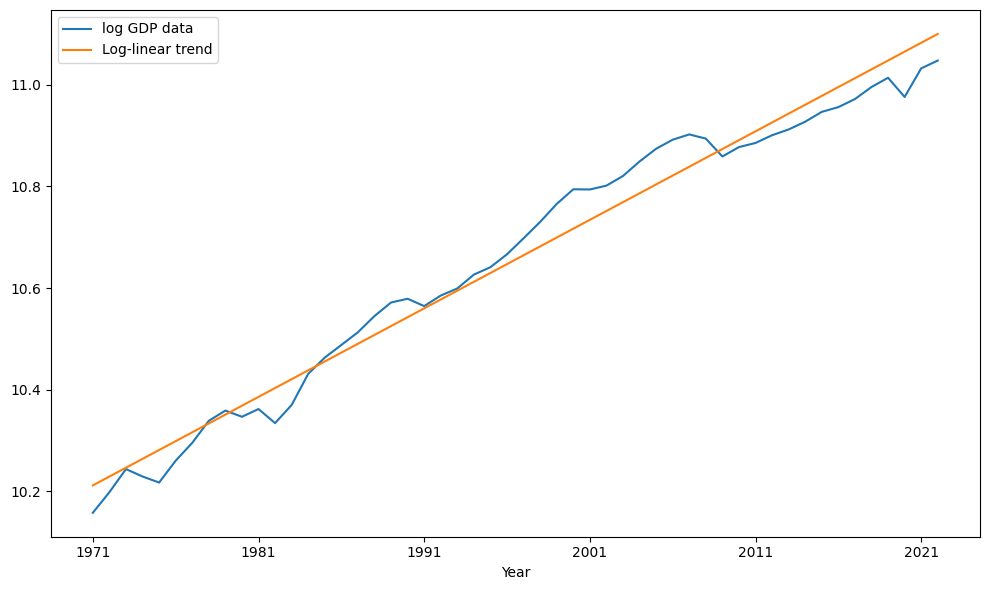

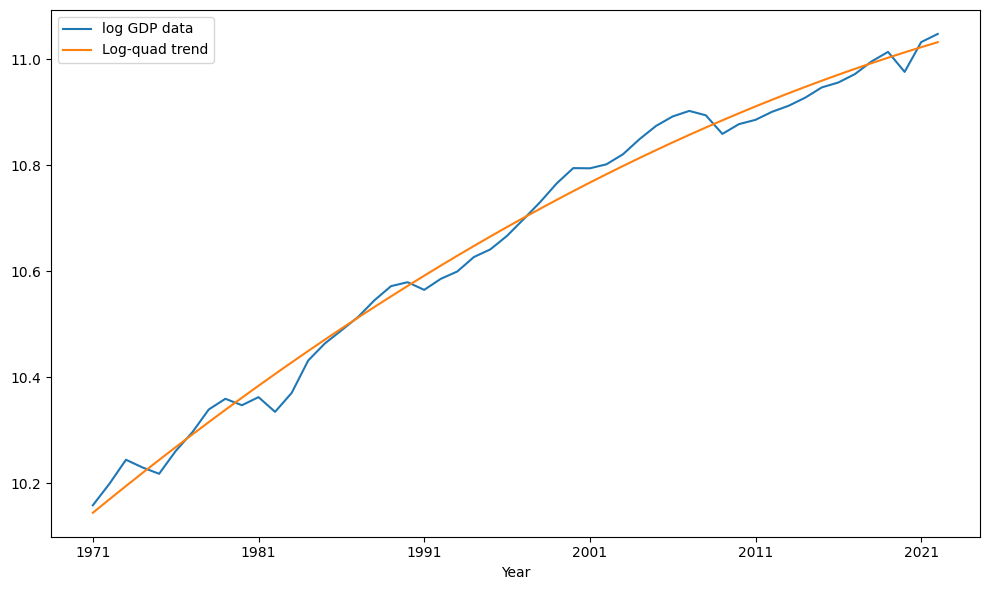

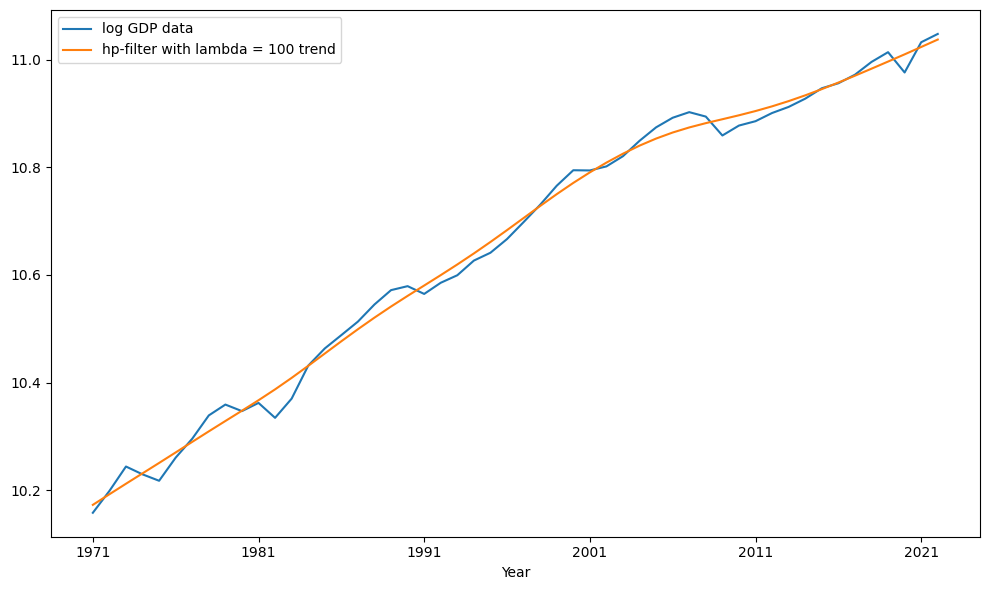

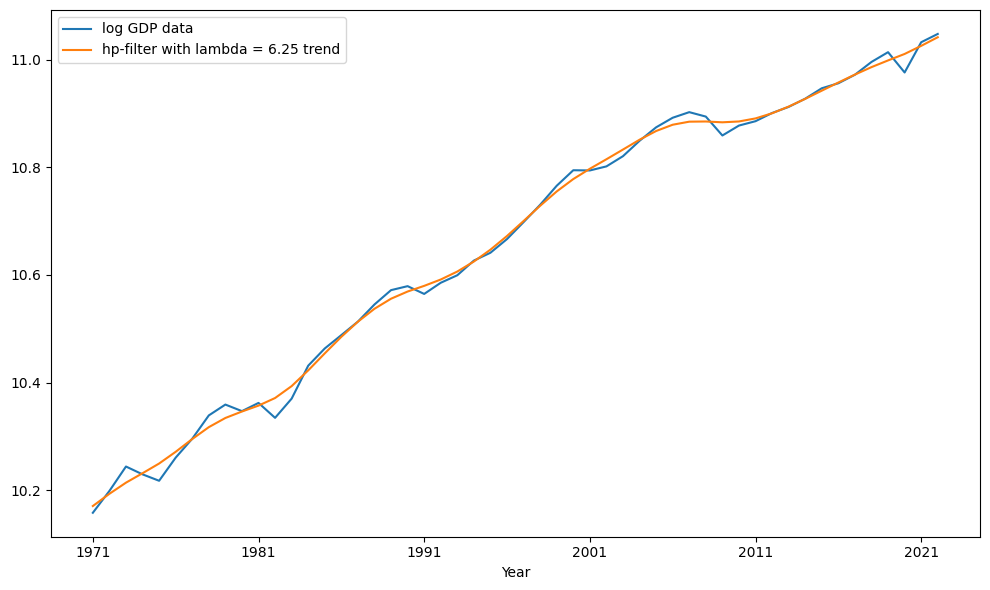

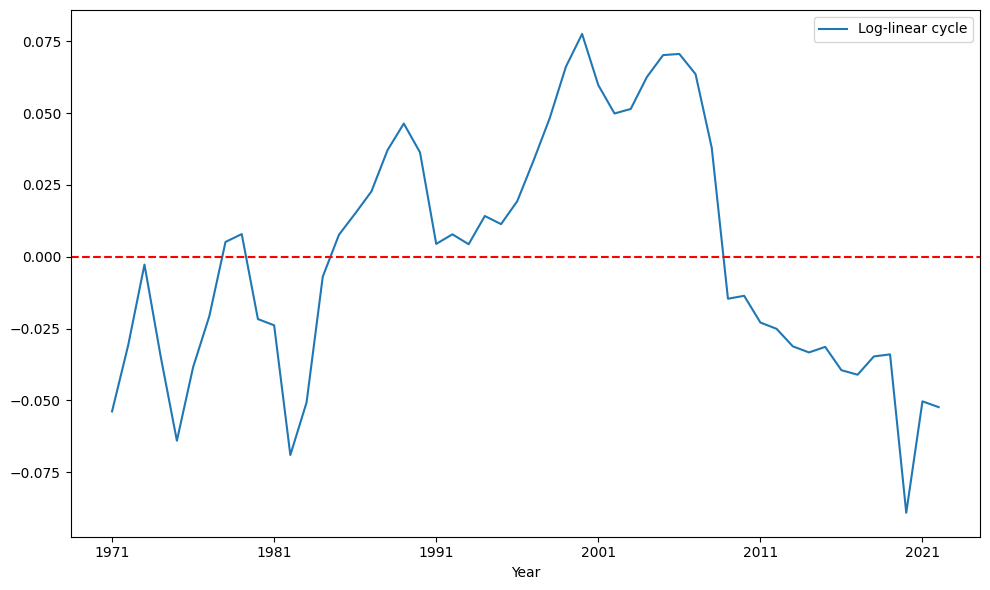

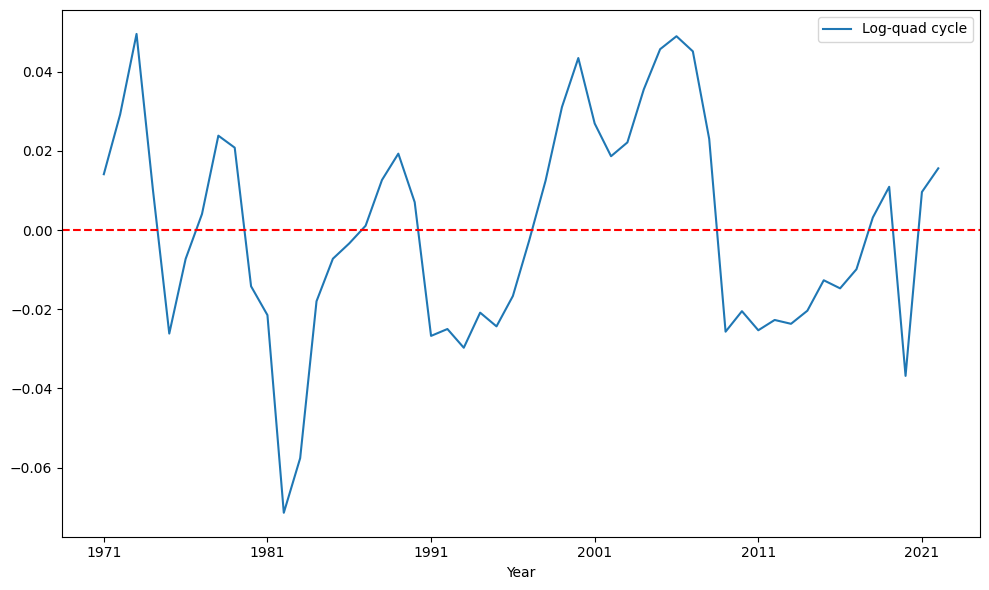

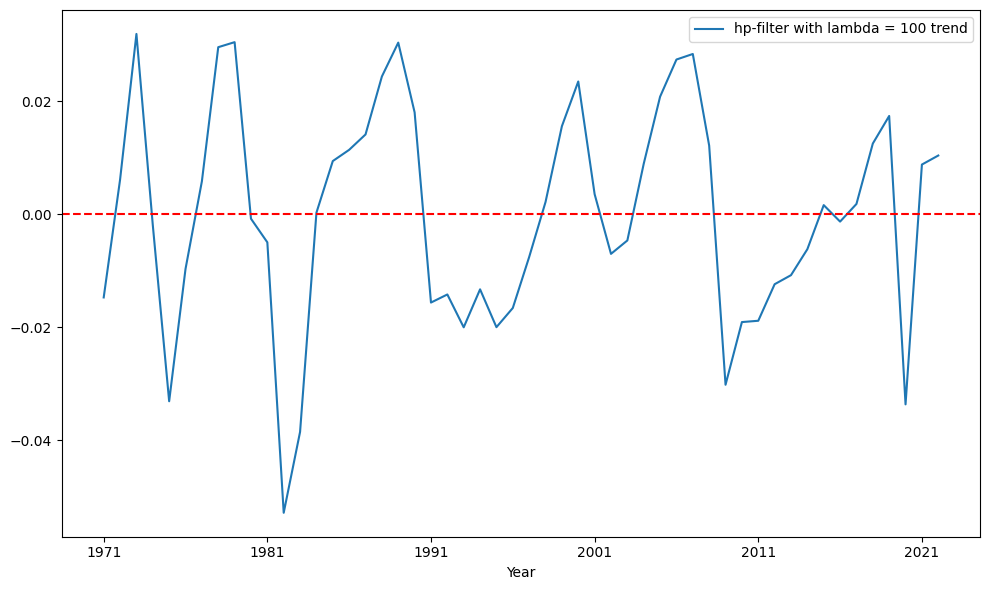

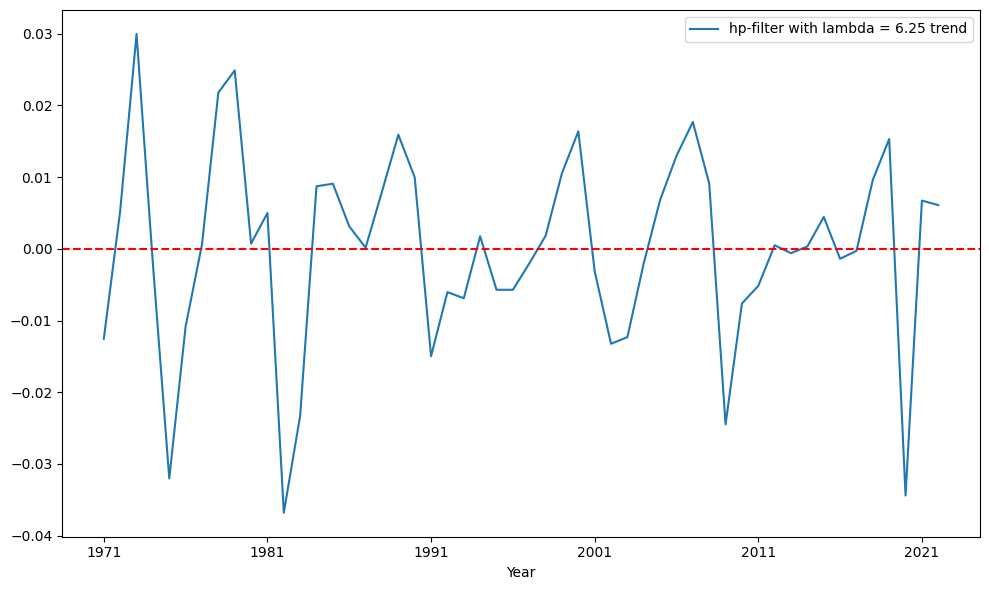

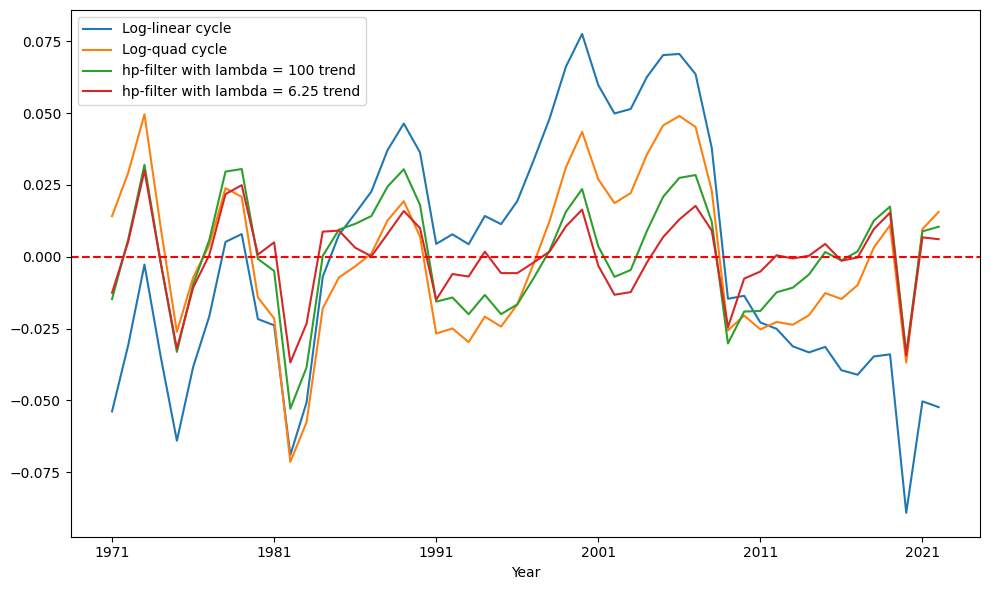

In [46]:
usa_part_1 = solve_first_part_of_task(usa_data_log, indicators)

Общий график показывает, что динамика всех методов схожа, но в частностях есть отличия. Лог-линейный цикл сильно отличается от остальных, имея значительные отклонения как в начале, так и в конце.

#### Результаты первой части для Индии

Statistics for log_linear_detrending
                            OLS Regression Results                            
Dep. Variable:                      x   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     1703.
Date:                Sun, 19 May 2024   Prob (F-statistic):           2.72e-40
Time:                        18:25:34   Log-Likelihood:                 48.027
No. Observations:                  52   AIC:                            -92.05
Df Residuals:                      50   BIC:                            -88.15
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -6

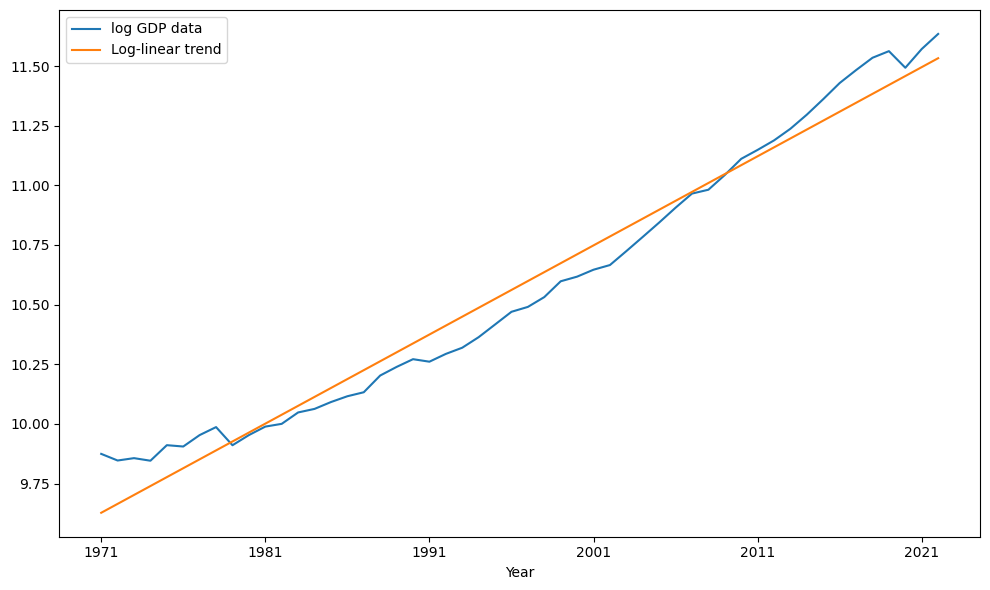

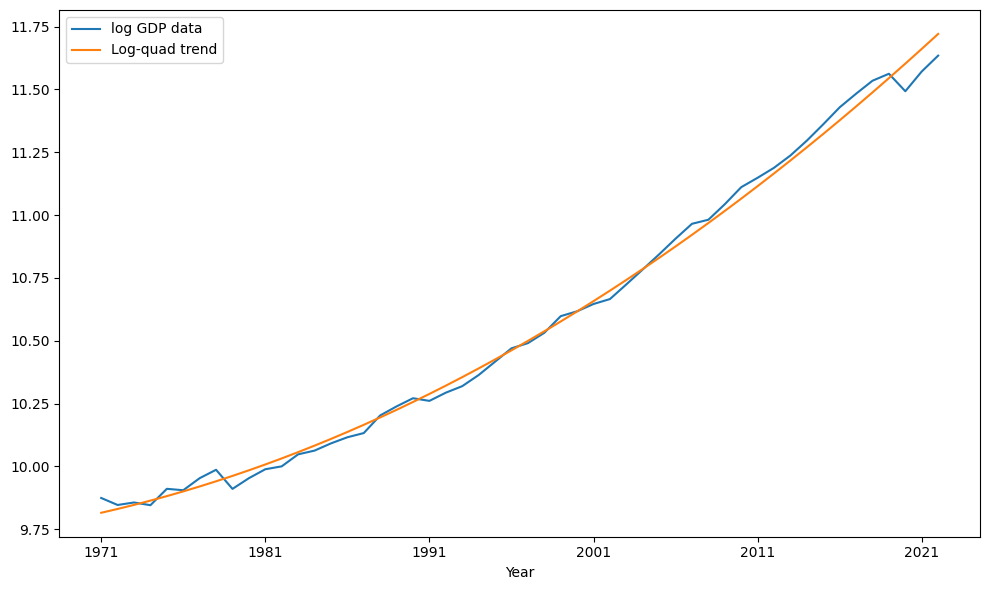

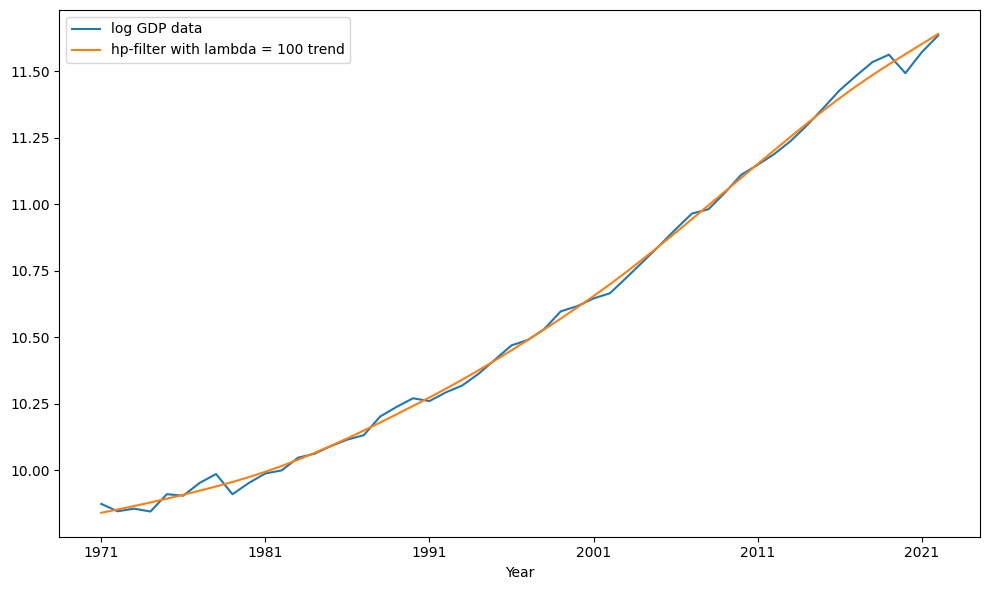

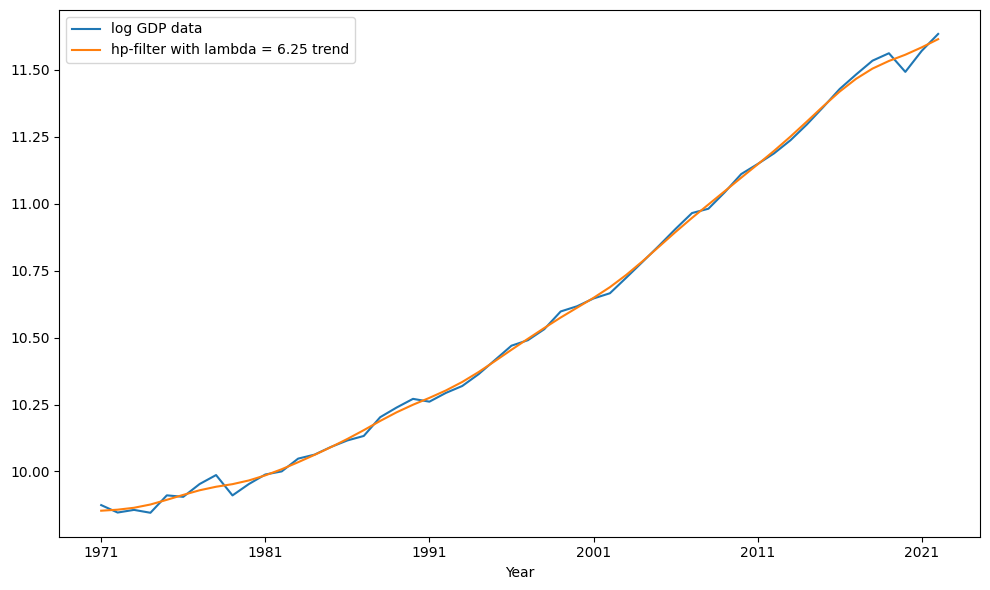

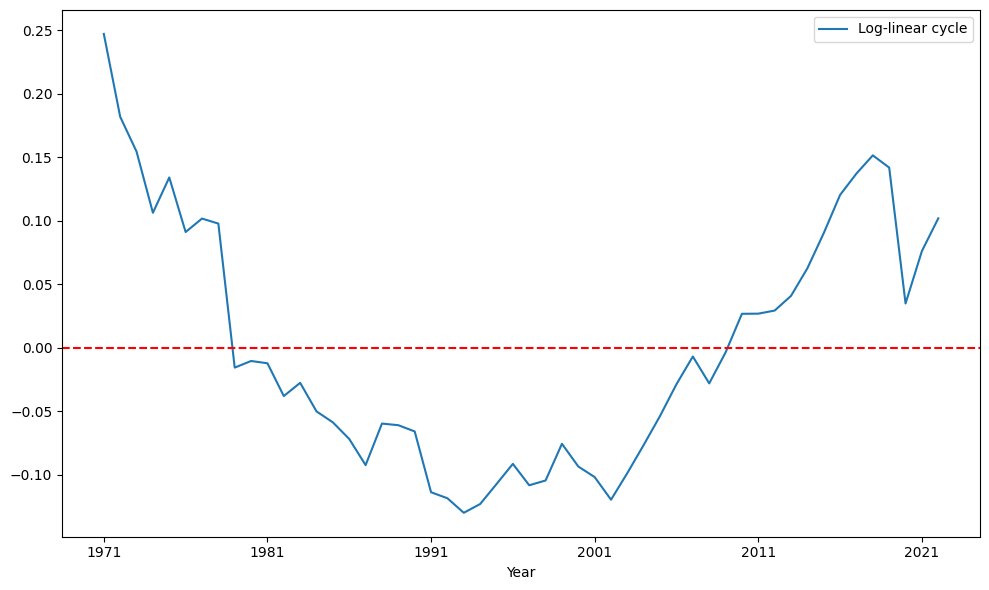

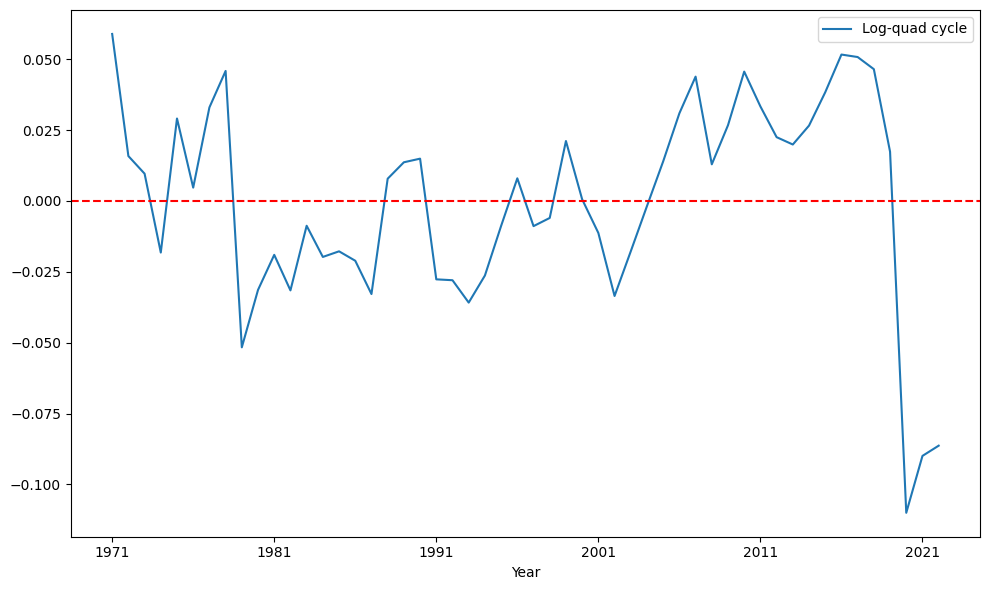

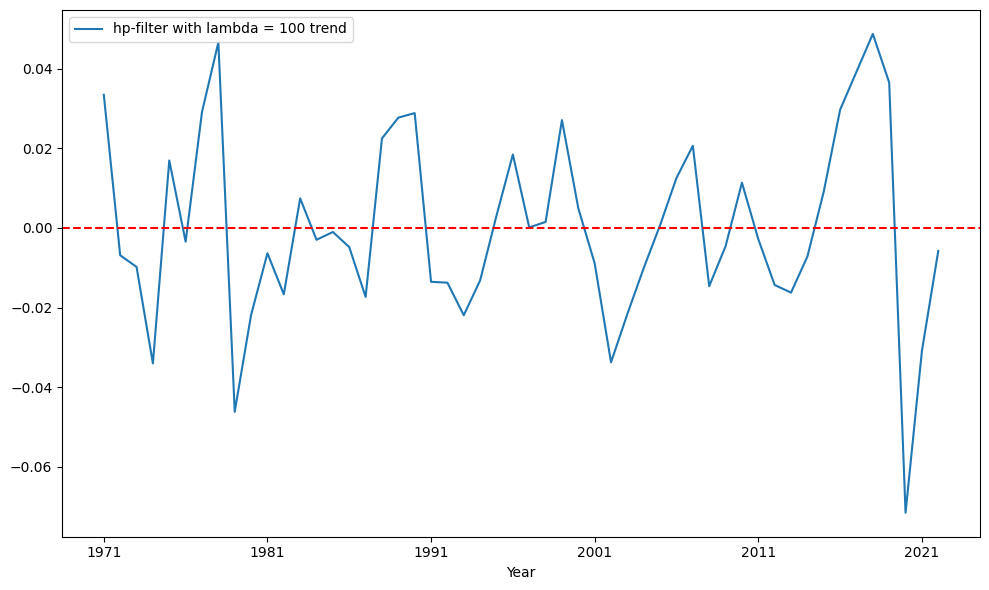

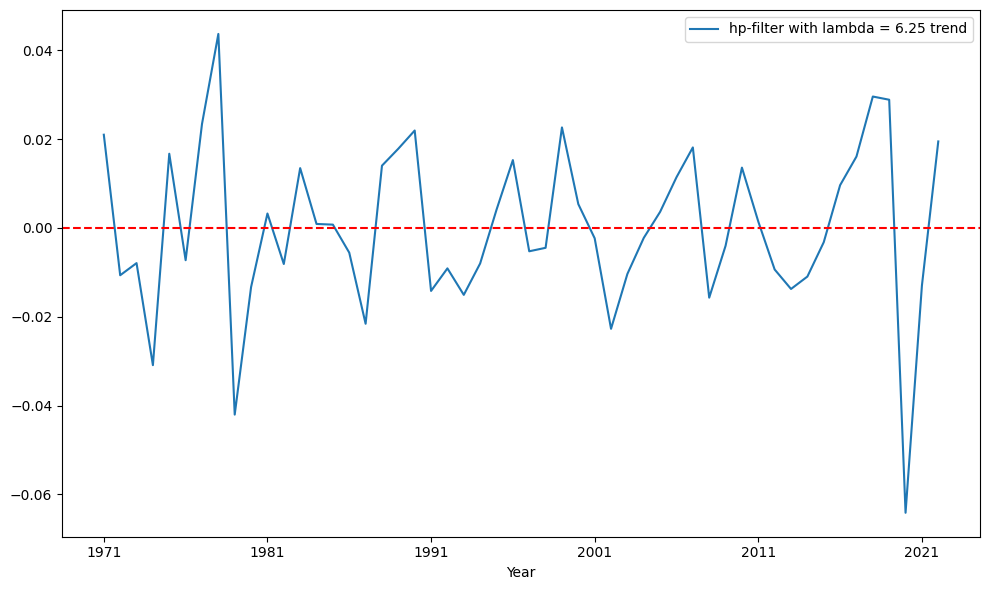

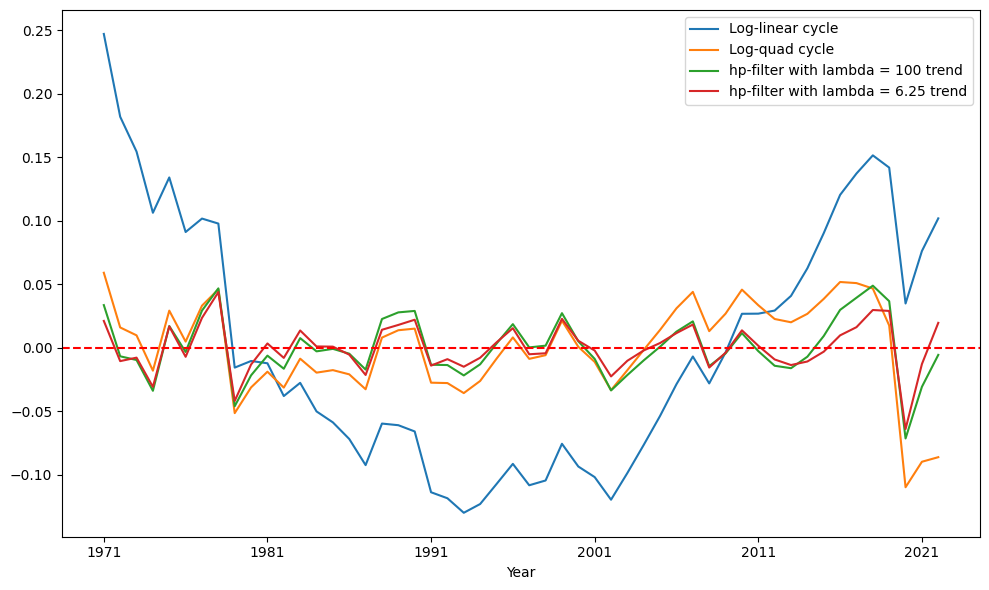

In [47]:
ind_part_1 = solve_first_part_of_task(ind_data_log, indicators)

Лог-линейный цикл для Индии существенно отличается от остальных методов

### Часть II

Находим корреляцию полученных в части 1 циклов между странами

In [48]:
print(f"Correlation of log-linear cycles:                    {usa_part_1[methods[0]][0].corr(ind_part_1[methods[0]][0])}")
print(f"Correlation of log-quad cycles:                      {usa_part_1[methods[1]][0].corr(ind_part_1[methods[1]][0])}")
print(f"Correlation of hp-filters with lambda = 100 cycles:  {usa_part_1[methods[2]][0].corr(ind_part_1[methods[2]][0])}")
print(f"Correlation of hp-filters with lambda = 6.25 cycles: {usa_part_1[methods[3]][0].corr(ind_part_1[methods[3]][0])}")

Correlation of log-linear cycles:                    -0.6706354569161798
Correlation of log-quad cycles:                      0.1752002653963771
Correlation of hp-filters with lambda = 100 cycles:  0.29506020603556876
Correlation of hp-filters with lambda = 6.25 cycles: 0.2886334362304061


In [49]:
def create_cycle_array(data):
    return pd.DataFrame({methods[0]:data[methods[0]][0], methods[1]:data[methods[1]][0], methods[2]:data[methods[2]][0], methods[3]:data[methods[3]][0]})

#### Корреляция циклов в данных США

In [51]:
usa_cycle_array = create_cycle_array(usa_part_1)

Посчитаем статистики по циклам США как в учебнике

In [53]:
usa_cycle_array.describe()

,log-linear,log-quad,hp-filter100,hp-filter6.25
count,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01
mean,2.398082e-14,-4.060342e-13,-2.309264e-14,-5.738999e-15
std,4.229849e-02,2.706223e-02,1.954636e-02,1.389708e-02
min,-8.910498e-02,-7.139948e-02,-5.288118e-02,-3.680996e-02
25%,-3.347456e-02,-2.099997e-02,-1.351269e-02,-5.790126e-03
50%,8.089103e-04,-7.393445e-04,9.678644e-04,5.593281e-04
75%,3.651602e-02,1.969353e-02,1.295045e-02,8.817710e-03
max,7.752296e-02,4.955450e-02,3.197088e-02,2.997737e-02


Ковариации методов

In [54]:
usa_cycle_array.cov()

,log-linear,log-quad,hp-filter100,hp-filter6.25
log-linear,0.001789,0.000732,0.000452,0.000261
log-quad,0.000732,0.000732,0.000449,0.000261
hp-filter100,0.000452,0.000449,0.000382,0.000248
hp-filter6.25,0.000261,0.000261,0.000248,0.000193


#### Корреляция циклов в данных Индии

In [55]:
ind_cycle_array = create_cycle_array(ind_part_1)

Посчитаем статистики по циклам Индии как в учебнике

In [56]:
ind_cycle_array.describe()

,log-linear,log-quad,hp-filter100,hp-filter6.25
count,5.200000e+01,5.200000e+01,5.200000e+01,5.200000e+01
mean,-9.363450e-14,-1.004666e-13,3.808919e-14,-6.422213e-15
std,9.702132e-02,3.633559e-02,2.379714e-02,1.886564e-02
min,-1.300909e-01,-1.099783e-01,-7.156027e-02,-6.415343e-02
25%,-8.032901e-02,-2.008067e-02,-1.390632e-02,-1.044424e-02
50%,-2.177881e-02,6.273435e-03,-3.217710e-03,-2.302895e-03
75%,9.031823e-02,2.660943e-02,1.731492e-02,1.431828e-02
max,2.469445e-01,5.890259e-02,4.872544e-02,4.366220e-02


Ковариации методов

In [57]:
ind_cycle_array.cov()

,log-linear,log-quad,hp-filter100,hp-filter6.25
log-linear,0.009413,0.001320,0.000712,0.000441
log-quad,0.001320,0.001320,0.000668,0.000438
hp-filter100,0.000712,0.000668,0.000566,0.000422
hp-filter6.25,0.000441,0.000438,0.000422,0.000356


## Таблица 1.3

### Теперь нам предстоит создать аналог таблицы 1.3 из учебника Uribe. Для этого мы должны определить бизнес-циклы для всех имеющихся индикаторов. Мы будем использовать метод hpfilter с параметром сглаживания (lambda) равным 100 для вычисления этих циклов.

In [74]:
def calc_all_cycles(data):
    return [hp_filter(data, indicators[0], 100, False),    # 'GDP per capita'
            hp_filter(data, indicators[1], 100, False),    # 'Households and NPISHs final consumption expenditure'   
            hp_filter(data, indicators[2], 100, False),    # 'Gross capital formation'
            hp_filter(data, indicators[3], 100, False),    # 'General government final consumption expenditure'    
            hp_filter(data, indicators[4], 100, False),    # 'Imports of goods and services'    
            hp_filter(data, indicators[5], 100, False),]   # 'Exports of goods and services'    

def calc_all_std(data):
    return [data[0][0].std(),
            data[1][0].std(),
            data[2][0].std(),
            data[3][0].std(),
            data[4][0].std(),
            data[5][0].std()] 

In [75]:
usa_cycles = calc_all_cycles(usa_data_log)
ind_cycles = calc_all_cycles(ind_data_log)
usa_cycles_std = calc_all_std(usa_cycles)
ind_cycles_std = calc_all_std(ind_cycles)

Вычисляем значения и строим таблицу 1.3

In [76]:
name_1 = 'std_' + indicators_info[indicators[0]]
name_2 = 'std_' + indicators_info[indicators[1]]
name_3 = 'std_' + indicators_info[indicators[2]]
name_4 = 'std_' + indicators_info[indicators[3]]
name_5 = 'std_' + indicators_info[indicators[4]]
name_6 = 'std_' + indicators_info[indicators[5]]
cycle_name_1 = 'cycle '+ indicators[0]
cycle_name_2 = 'cycle '+ indicators[0]
cycle_name_3 = 'cycle '+ indicators[0]
cycle_name_4 = 'cycle '+ indicators[0]
cycle_name_5 = 'cycle '+ indicators[0]
cycle_name_6 = 'cycle '+ indicators[0]
Name_row = [name_1, name_2, name_3, name_4, name_5, name_6, \
                                          f'{name_2}/{name_1}', f'{name_3}/{name_1}',  f'{name_4}/{name_1}', \
                                            f'{name_5}/{name_1}', f'{name_6}/{name_1}', \
                              f'corr({cycle_name_1}, {cycle_name_2})', f'corr({cycle_name_1}, {cycle_name_3})', \
                                f'corr({cycle_name_1}, {cycle_name_4})', f'corr({cycle_name_1}, {cycle_name_5})', f'corr({cycle_name_1}, {cycle_name_6})']
India_row = [ind_cycles_std[0], ind_cycles_std[1], ind_cycles_std[2], \
                                  ind_cycles_std[3], ind_cycles_std[4], ind_cycles_std[5], \
                            ind_cycles_std[1]/ind_cycles_std[0], ind_cycles_std[2]/ind_cycles_std[0], \
                              ind_cycles_std[3]/ind_cycles_std[0], ind_cycles_std[4]/ind_cycles_std[0], ind_cycles_std[5]/ind_cycles_std[0], \
                              np.corrcoef(ind_cycles[0], ind_cycles[1]), np.corrcoef(ind_cycles[0], ind_cycles[2]), np.corrcoef(ind_cycles[0], ind_cycles[3]), \
                                np.corrcoef(ind_cycles[0], ind_cycles[4]), np.corrcoef(ind_cycles[0], ind_cycles[5])]
USA_row = [usa_cycles_std[0], usa_cycles_std[1], usa_cycles_std[2], \
                                  usa_cycles_std[3], usa_cycles_std[4], usa_cycles_std[5], \
                            usa_cycles_std[1]/usa_cycles_std[0], usa_cycles_std[2]/usa_cycles_std[0], \
                              usa_cycles_std[3]/usa_cycles_std[0], usa_cycles_std[4]/usa_cycles_std[0], usa_cycles_std[5]/usa_cycles_std[0], \
                              np.corrcoef(usa_cycles[0], usa_cycles[1]), np.corrcoef(usa_cycles[0], usa_cycles[2]), np.corrcoef(usa_cycles[0], usa_cycles[3]), \
                                np.corrcoef(usa_cycles[0], usa_cycles[4]), np.corrcoef(usa_cycles[0], usa_cycles[5])]
result_2_table = pd.DataFrame({"Name": Name_row,
                          "India": India_row,
                          "USA": USA_row})

In [77]:
def round_values(value):
    if isinstance(value, (float, np.float64)):
        return round(value, 5)
    elif isinstance(value, np.ndarray):
        return np.round(value, 5)
    else:
        return value
result_2_table_rounded = result_2_table.applymap(round_values)

C:\Users\Владимир\AppData\Local\Temp\ipykernel_6004\2313556686.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_2_table_rounded = result_2_table.applymap(round_values)


In [78]:
result_2_table_rounded

,Name,India,USA
0,std_GDP per capita,0.0238,0.01955
1,std_Households and NPISHs final consumption ex...,0.01695,0.00702
2,std_Gross capital formation,0.07023,0.04892
3,std_General government final consumption expen...,0.04502,0.03001
4,std_Imports of goods and services,0.09542,0.05653
5,std_Exports of goods and services,0.08733,0.07924
6,std_Households and NPISHs final consumption ex...,0.71217,0.35938
7,std_Gross capital formation/std_GDP per capita,2.95116,2.50299
8,std_General government final consumption expen...,1.89183,1.53544
9,std_Imports of goods and services/std_GDP per ...,4.0097,2.89212


Выведем матрицы корреляции отдельно

Индия

In [79]:
print(np.corrcoef(ind_cycles[0], ind_cycles[1]),"\n--\n", np.corrcoef(ind_cycles[0], ind_cycles[2]),"\n--\n", np.corrcoef(ind_cycles[0], ind_cycles[3]),"\n--\n", \
                                np.corrcoef(ind_cycles[0], ind_cycles[4]),"\n--\n", np.corrcoef(ind_cycles[0], ind_cycles[5]))

[[ 1.          0.01065633 -0.25852602 -0.00841816]
 [ 0.01065633  1.         -0.00243262 -0.89364562]
 [-0.25852602 -0.00243262  1.          0.06627308]
 [-0.00841816 -0.89364562  0.06627308  1.        ]] 
--
 [[ 1.00000000e+00  1.06563326e-02  4.70926962e-02 -3.98365348e-03]
 [ 1.06563326e-02  1.00000000e+00 -4.74698512e-04  8.48186111e-01]
 [ 4.70926962e-02 -4.74698512e-04  1.00000000e+00  9.75407869e-02]
 [-3.98365348e-03  8.48186111e-01  9.75407869e-02  1.00000000e+00]] 
--
 [[ 1.          0.01065633 -0.03190537 -0.01792857]
 [ 0.01065633  1.         -0.00107478  0.48537517]
 [-0.03190537 -0.00107478  1.          0.09430003]
 [-0.01792857  0.48537517  0.09430003  1.        ]] 
--
 [[ 1.          0.01065633 -0.12887366 -0.0079844 ]
 [ 0.01065633  1.         -0.00200925  0.94705231]
 [-0.12887366 -0.00200925  1.          0.08031515]
 [-0.0079844   0.94705231  0.08031515  1.        ]] 
--
 [[ 1.00000000e+00  1.06563326e-02 -1.58301400e-01 -3.52183572e-03]
 [ 1.06563326e-02  1.00000000

In [80]:
print(np.corrcoef(usa_cycles[0], usa_cycles[1]),"\n--\n", np.corrcoef(usa_cycles[0], usa_cycles[2]),"\n--\n", np.corrcoef(usa_cycles[0], usa_cycles[3]),"\n--\n", \
                                np.corrcoef(usa_cycles[0], usa_cycles[4]),"\n--\n", np.corrcoef(usa_cycles[0], usa_cycles[5]))

[[ 1.          0.01352774 -0.3537803   0.01176915]
 [ 0.01352774  1.          0.00556298  0.99549673]
 [-0.3537803   0.00556298  1.          0.02015558]
 [ 0.01176915  0.99549673  0.02015558  1.        ]] 
--
 [[ 1.          0.01352774  0.76377291  0.11738403]
 [ 0.01352774  1.          0.00752578 -0.74850826]
 [ 0.76377291  0.00752578  1.          0.23194205]
 [ 0.11738403 -0.74850826  0.23194205  1.        ]] 
--
 [[ 1.          0.01352774 -0.63689002 -0.01266201]
 [ 0.01352774  1.         -0.00169922 -0.88486461]
 [-0.63689002 -0.00169922  1.          0.17793432]
 [-0.01266201 -0.88486461  0.17793432  1.        ]] 
--
 [[1.         0.01352774 0.46849522 0.00409255]
 [0.01352774 1.         0.00148533 0.96525918]
 [0.46849522 0.00148533 1.         0.06361848]
 [0.00409255 0.96525918 0.06361848 1.        ]] 
--
 [[ 1.          0.01352774 -0.06105896 -0.05525689]
 [ 0.01352774  1.         -0.00991928  0.96323879]
 [-0.06105896 -0.00991928  1.          0.1383689 ]
 [-0.05525689  0.963238

Заключение: При использовании метода фильтра Ходрик-Перскотта мы наблюдаем, что волатильность потребления в государственном секторе превышает волатильность выпуска, а также потребление в государственном секторе демонстрирует отрицательную корреляцию с ВВП. Эти наблюдения соответствуют данным из учебника, что подтверждает их на практике. При анализе ВВП с использованием hp-фильтра мы также обнаруживаем положительную корреляцию между ВВП и импортом товаров, а также между ВВП и валовым накоплением капитала. Особенно высокая корреляция наблюдается между циклами ВВП и валового накопления капитала.